In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [1]:
url = "https://drive.google.com/file/d/1c5210z-HSQ-Kv4EExbYIjjPq6lT0UYZW/view?usp=sharing" #housing prices iter 7
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
house = pd.read_csv(path)
# house = house.sample(100).copy() # small sample to quickly test the pipeline

X = house.drop(columns=['Id','SalePrice'])
y = house['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

NameError: ignored

In [ ]:
# numeric cols
num_cols = X_train.select_dtypes(exclude=['object']).columns

# ordinal cols
ord_cols = ['ExterQual','ExterCond','KitchenQual','FireplaceQu']
qualities = ["Po", "Fa", "TA", "Gd", "Ex"]
na_qualities = ["missing","Po", "Fa", "TA", "Gd", "Ex"]
ord_cols_categories = [qualities for l in range(3)] + [na_qualities]
assess: len(ord_cols) == len(ord_cols_categories)

# nominal cols
nom_cols = (
    X_train
    .drop(columns=ord_cols)
    .select_dtypes(include=['object'])
    .columns)


# numeric pipeline
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

# ordinal pipeline
ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value="missing")),
    ('encoder', OrdinalEncoder(handle_unknown="use_encoded_value",
                               unknown_value=-1)
    )
])

# nominal pipeline
nom_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value="missing")),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipe, num_cols),
        ('nom', nom_pipe, nom_cols),
        ('ord', ord_pipe, ord_cols)
])

# model pipeline
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('var_threshold', VarianceThreshold()),
    ('mod_feature_sel', SelectFromModel(DecisionTreeRegressor())),
    # apply different models here
    ('model', KNeighborsRegressor())
])

In [ ]:
# grid search parameters
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__ord__imputer__strategy': ['most_frequent', 'constant'],
    'preprocessor__nom__imputer__strategy': ['most_frequent', 'constant'],
    'var_threshold__threshold': [0, 0.01, 0.02],
    'mod_feature_sel__estimator__max_features': [None, 
                                                 'auto', 
                                                 'sqrt', 
                                                 'log2'],
    'mod_feature_sel__estimator__min_samples_leaf': [1, 2, 4],
    'model': [DecisionTreeRegressor(), 
              KNeighborsRegressor(),
              LinearRegression(), 
              RandomForestRegressor(), 
              GradientBoostingRegressor()]
}

# grid search + cross validation
grid_search = GridSearchCV(model_pipe, 
                           param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2nd...
                         'model': [DecisionTreeRegressor(),
                                   KNeighborsRegressor(), LinearRegression(),
                                   RandomForestRegressor(),
                                   GradientBoostingRegressor()],
                         'preprocessor__nom__imputer__strategy': ['most_frequent',
                                                                  'constant'],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median'],
                         'preprocessor__ord__imputer__strategy': ['most_frequent',
                                                                  'constant'],
                         'var_threshold__threshold': [0, 0.01, 0.02]},
             verbose=2)

In [ ]:
grid_search.best_params_

{'mod_feature_sel__estimator__max_features': 'log2',
 'mod_feature_sel__estimator__min_samples_leaf': 1,
 'model': RandomForestRegressor(),
 'preprocessor__nom__imputer__strategy': 'most_frequent',
 'preprocessor__num__imputer__strategy': 'median',
 'preprocessor__ord__imputer__strategy': 'constant',
 'var_threshold__threshold': 0}

In [ ]:
grid_search.best_score_

0.8609105389953655

In [ ]:
# get predictions
predictions_train = grid_search.predict(X_train)

# evaluate the model
print(f"R2 score: {r2_score(y_train, predictions_train)}")
print(f"MSE: {mean_squared_error(y_train, predictions_train)}")
print(f"MAE: {mean_absolute_error(y_train, predictions_train)}")


R2 score: 0.9800570589951133
MSE: 122787893.7926769
MAE: 6595.152226027398


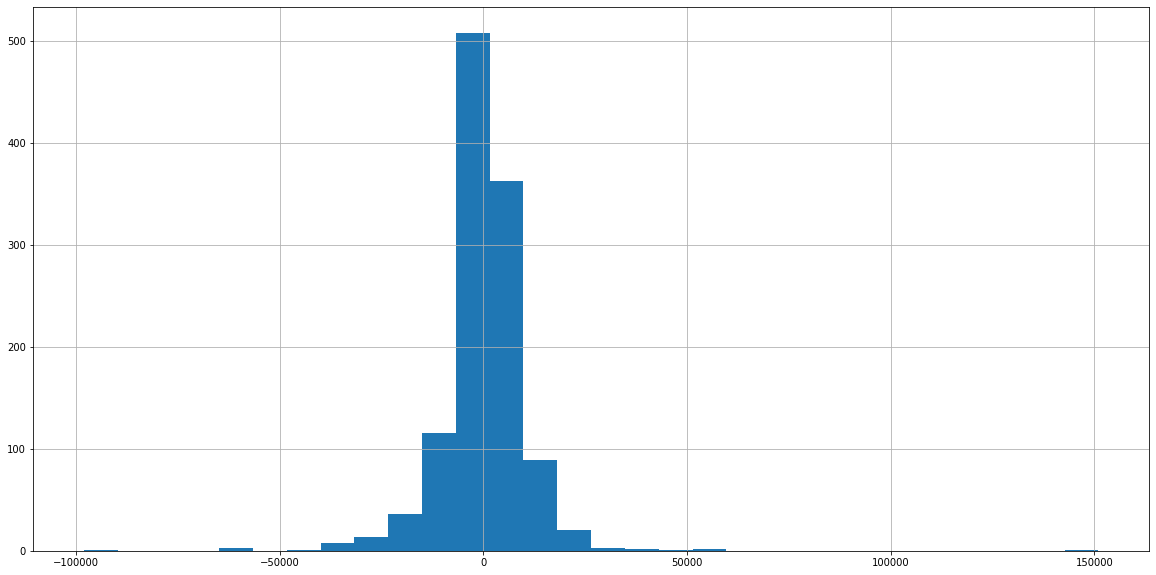

In [ ]:
# distribution of errors
(predictions_train - y_train).hist(bins=30, figsize=(20,10));

In [ ]:
# get predictions
predictions_test = grid_search.predict(X_test)

# evaluate the model
print(f"R2 score: {r2_score(y_test, predictions_test)}")
print(f"MSE: {mean_squared_error(y_test, predictions_test)}")
print(f"MAE: {mean_absolute_error(y_test, predictions_test)}")


R2 score: 0.6252943148106604
MSE: 2587661242.5767317
MAE: 23638.474383553064


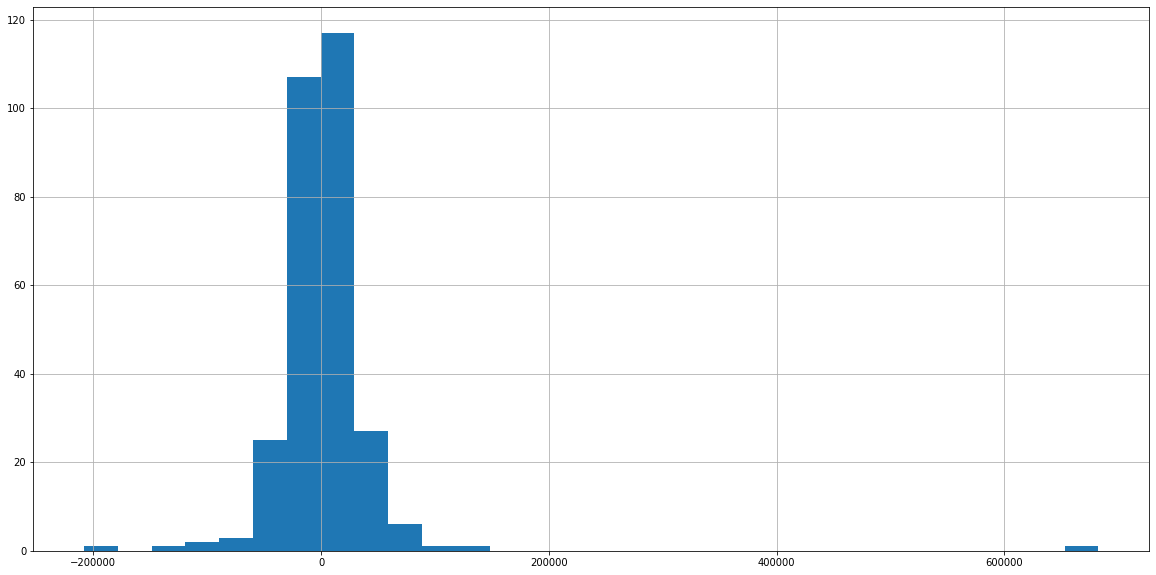

In [ ]:
# distribution of errors
(predictions_test - y_test).hist(bins=30, figsize=(20,10));